# Neon Kafka Data for the Burn Event (MDP5) 

Available data from the Kafka stream:
- 'reading.sensor.prt', - Singal aspirated air temperature
- 'reading.sensor.mti300ahrs', - 3D wind attitude and motion reference
- 'reading.sensor.li191r', - Photosynthetically active radiation (quantum line)
- 'event.rtu.pump',
- 'reading.phenocam.rgbimage', - Phenology images [RGB]
- 'reading.sensor.hfp01sc', - Soil heat flux plate
- 'reading.sensor.mcseries',
- 'reading.sensor.picarro3way',
- 'reading.sensor.hmp155', - Relative humidity
- 'event.cnc.ecte',
- 'reading.sensor.t7610', - Precipitation
- 'reading.sensor.csat3', - 3D wind speed, direction and sonic temperature
- 'reading.sensor.pqs1', - Photosynthetically active radiation (PAR)
- 'reading.sensor.mwseries',
- 'event.rtu.grape',
- 'reading.sensor.g2131i_raw', - Atmospheric CO2 isotopes
- 'event.cnc.ecse',
- 'event.rtu.events',
- 'reading.sensor.nr01', - Shortwave and longwave radiation (net radiometer)
- 'reading.sensor.grape',
- 'reading.sensor.windobserverii', - 2D wind speed and direction
- 'reading.sensor.pressuretransducer',
- 'reading.sensor.li840a', - CO2 concentration storage
- 'event.cnc.pumps',
- 'reading.sensor.si111', - IR biological temperature
- 'reading.sensor.ptb330a', - Barometric pressure
- 'reading.sensor.li7200_raw', - CO2 and H2O concentrations turbulent
- 'reading.sensor.pump',
- 'reading.sensor.dualfan',
- 'reading.sensor.l2130i_raw', - Atmospheric H2O isotopes
- 'reading.phenocam.irimage', - Phenology images (IR)

Files provided for the burn event:
- 'reading.sensor.li191r', - Photosynthetically active radiation (quantum line)
- 'reading.sensor.pqs1', - Photosynthetically active radiation (PAR)
- 'reading.sensor.mti300ahrs', - 3D wind attitude and motion reference
- 'reading.sensor.ptb330a', - Barometric pressure
- 'reading.sensor.li7200_raw', - CO2 and H2O concentrations turbulent
- 'reading.sensor.hfp01sc', - Soil heat flux plate
- 'reading.sensor.li840a', - CO2 concentration storage
- 'reading.sensor.t7610', - Precipitation
- 'reading.sensor.g2131i_raw', - Atmospheric CO2 isotopes
- 'reading.sensor.prt', - Singal aspirated air temperature
- 'reading.sensor.windobserverii', - 2D wind speed and direction
- 'reading.sensor.hmp155', - Relative humidity
- 'reading.sensor.pressuretransducer',
- 'reading.sensor.si111', - IR biological temperature
- 'reading.sensor.l2130i_raw', - Atmospheric H2O isotopes
- 'reading.sensor.csat3', - 3D wind speed, direction and sonic temperature
- 'reading.sensor.nr01', - Shortwave and longwave radiation (net radiometer)

For each file, refer to the Algorithm Theoretical Basis Document ATBD for each variable on [NEONs Data portal](https://data.neonscience.org/data-products/explore) to convert the raw data to useable data. For example, `reading.sensor.windobserverii` corresponds to [2D Wind Speed and direction](https://data.neonscience.org/data-products/DP1.00001.001/RELEASE-2021) with the following [ATBD document](https://data.neonscience.org/api/v0/documents/NEON.DOC.000780vB)

## Get datasets from CKAN

In [1]:
from ckanapi import RemoteCKAN
import pandas as pd
import requests
from requests.exceptions import HTTPError
import pickle
from shapely.geometry import shape
import geopandas as gpd
import contextily as ctx
import json

In [2]:
wifire_commons = RemoteCKAN("https://wifire-data.sdsc.edu")

In [3]:
packages = wifire_commons.action.package_search(q='+organization:sage-neon')
neon_sage_datasets = pd.DataFrame(packages['results'])
num_resources = neon_sage_datasets['num_resources'].to_list()
print('Number of resources: ' + str(num_resources))
neon_sage_datasets.T

Number of resources: [27]


,0
license_title,Creative Commons Attribution 4.0
maintainer,
relationships_as_object,[]
private,False
maintainer_email,
num_tags,1
id,335fa1cb-d6d2-4e96-bc8e-c309d957b24d
metadata_created,2022-05-16T20:05:41.203471
metadata_modified,2022-05-18T22:10:16.261878
author,Ismael Perez


### View the location of the dataset by plotting the spatial extent in geopandas

In [4]:
neon_sage_datasets['spatial_extent'] = neon_sage_datasets.apply(lambda x: [extra['value'] for extra in x.extras if extra['key'] == 'spatial'],axis=1)
neon_sage_datasets['geometry'] = neon_sage_datasets.apply(lambda x: shape(json.loads(x.spatial_extent[0])),axis=1) # should only be one spatial extent
neon_sage_datasets_gdf = gpd.GeoDataFrame(neon_sage_datasets,crs="EPSG:4326").set_geometry('geometry')

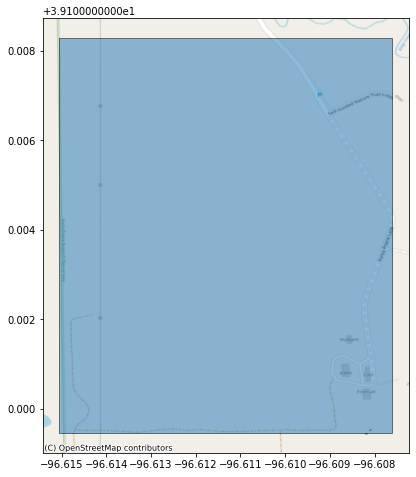

In [5]:
ax = neon_sage_datasets_gdf.plot(figsize=(8,8),alpha=0.5,edgecolor='k')
ctx.add_basemap(ax,crs=neon_sage_datasets_gdf.crs.to_string(),source=ctx.providers.OpenStreetMap.Mapnik)

In [6]:
resources = neon_sage_datasets.resources.to_list()[0] # pick one row from the above dataframe
neon_files = [(res['name'],res['url']) for res in resources if res['name'].startswith('reading.') and res['name'].endswith('.pkl')]
print(neon_files)

[('reading.sensor.csat3.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.csat3.pkl'), ('reading.sensor.g2131i_raw.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.g2131i_raw.pkl'), ('reading.sensor.hfp01sc.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.hfp01sc.pkl'), ('reading.sensor.hmp155.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.hmp155.pkl'), ('reading.sensor.l2130i_raw.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.l2130i_raw.pkl'), ('reading.sensor.li191r.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.li191r.pkl'), ('reading.sensor.li7200_raw.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/data/reading.sensor.li7200_raw.pkl'), ('reading.sensor.li840a.pkl', 'https://wifire-data.sdsc.edu/data/neon/220415-burnevent/data/d

## Download data from wifire-commons, read file, load to Pandas dataframe

In [7]:
def download_data(url,file_name):
    try:
        rcv = requests.get(url)
        rcv.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')

    with open(file_name, 'wb') as f:
        f.write(rcv.content)
        f.close()
    return

### Pick one pickle file to download from the list of tuples

In [8]:
ith_pkl = 0
file_name=neon_files[ith_pkl][0]
data_url = neon_files[ith_pkl][1]
print('topic: ' + file_name)
download_data(data_url,file_name)

topic: reading.sensor.csat3.pkl


### Read data from pickle file

In [9]:
objects = []
with (open(file_name, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [10]:
sensor_data_df = pd.DataFrame(objects)
sensor_data_df

,source_id,site_id,readout_time,ux_wind_speed,uy_wind_speed,uz_wind_speed,speed_of_sound,flag_b15,flag_b14,flag_b13,flag_b12,counter
0,46586,MDP5,2022-04-15T11:59:59.951000+00:00,2.82700,3.48900,-0.20325,335.253998,False,False,False,False,b'\x16'
1,46586,MDP5,2022-04-15T12:00:00.001000+00:00,2.83650,3.50775,0.04675,335.248993,False,False,False,False,b'\x17'
2,46586,MDP5,2022-04-15T12:00:00.051000+00:00,2.90200,3.63000,-0.07225,335.252991,False,False,False,False,b'\x18'
3,46586,MDP5,2022-04-15T12:00:00.101000+00:00,2.88225,3.76275,-0.12775,335.257996,False,False,False,False,b'\x19'
4,46586,MDP5,2022-04-15T12:00:00.151000+00:00,2.83475,3.74775,-0.26650,335.252991,False,False,False,False,b'\x1a'
...,...,...,...,...,...,...,...,...,...,...,...,...
4679996,46586,MDP5,2022-04-18T04:59:59.750000+00:00,1.53175,2.13800,-0.08675,333.549011,False,False,False,False,b'\x19'
4679997,46586,MDP5,2022-04-18T04:59:59.800000+00:00,1.50875,2.12575,-0.11650,333.546997,False,False,False,False,b'\x1a'
4679998,46586,MDP5,2022-04-18T04:59:59.850000+00:00,1.52025,2.08650,-0.15150,333.541992,False,False,False,False,b'\x1b'
4679999,46586,MDP5,2022-04-18T04:59:59.900000+00:00,1.47750,2.05250,-0.24250,333.526001,False,False,False,False,b'\x1c'
